In [1]:

import pandas as pd
import numpy as np
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller


In [2]:
df = pd.read_csv(r'C:\Users\Auction_price.csv',index_col='year', parse_dates=True)
df.index.freq='MS'

In [3]:
df.head()


,price
year,
2018-04-01,104.69
2018-05-01,94.81
2018-06-01,92.14
2018-07-01,93.66
2018-08-01,96.34


In [4]:
import warnings
warnings.filterwarnings("ignore")

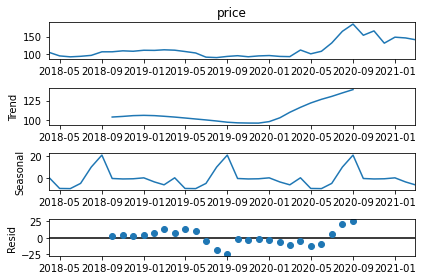

In [5]:
result = seasonal_decompose(df['price'], model='additive').plot()  # model='mul' also works

In [6]:
#Use pmdarima.auto_arima to determine ARIMA Orders
auto_arima(df['price'],error_action='ignore',seasonal = False).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -139.142
Date:                Fri, 08 Oct 2021   AIC                            280.284
Time:                        11:19:36   BIC                            281.839
Sample:                             0   HQIC                           280.821
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       166.1839     28.996      5.731      0.000     109.352     223.015
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 5.73
Prob(Q):                              0.46   Prob(JB):                         0.06
Heteroskedasticity (H):              22.43   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
#Get the train and test data
train_data = df.iloc[:25]
test_data = df.iloc[24:]

In [8]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(df['price'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.340098
p-value                  0.159361
# lags used              7.000000
# observations          28.000000
critical value (1%)     -3.688926
critical value (5%)     -2.971989
critical value (10%)    -2.625296
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [12]:
from statsmodels.tsa.statespace.tools import diff
df['diff_1'] = diff(df['price'], k_diff=1)


In [14]:
adf_test(df['diff_1'] )


Augmented Dickey-Fuller Test: 
ADF test statistic      -2.153066
p-value                  0.223718
# lags used              7.000000
# observations          27.000000
critical value (1%)     -3.699608
critical value (5%)     -2.976430
critical value (10%)    -2.627601
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Model is Non-stationary. Find the value of p,q given d=1 the order of differentiation

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

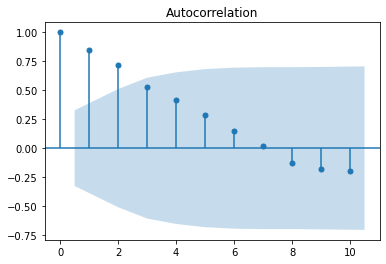

In [23]:
plot_acf(df['price'], lags=10);   # Autocorrelation gives the value of q=3 (MA)


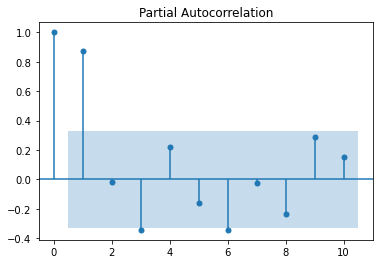

In [24]:
plot_pacf(df['price'], lags=10);  #p=2


In [25]:
stepwise_fit = auto_arima(df['price'], start_p=1, start_q=1,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=288.021, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=282.054, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=285.072, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=285.346, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=280.284, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=283.686, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=283.802, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=283.543, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=283.664, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=284.795, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.390 seconds


In [28]:
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults

In [29]:
model = ARIMA(train_data['price'],order=(1,2,1))
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.price   No. Observations:                   23
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -73.506
Method:                       css-mle   S.D. of innovations              5.636
Date:                Fri, 08 Oct 2021   AIC                            155.013
Time:                        11:38:21   BIC                            159.554
Sample:                    06-01-2018   HQIC                           156.155
                         - 04-01-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3789      0.366      1.035      0.301      -0.339       1.097
ar.L1.D2.price     0.4813      0.306      1.575      0.115      -0.118       1.080
ma.L1.D2.price    -1.0000      0.142     -7.047      0.000      -1.278      -0.722
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0775           +0.0000j            2.0775            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
#Make Prediction
start=len(train_data)
end=len(train_data)+len(test_data)-1

In [31]:
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,2,1) Predictions')


In [32]:
predictions

2020-05-01    123.021924
2020-06-01    130.981593
2020-07-01    137.490498
2020-08-01    143.497603
2020-09-01    149.459683
2020-10-01    155.596604
2020-11-01    162.014197
2020-12-01    168.763402
2021-01-01    175.868740
2021-02-01    183.342012
2021-03-01    191.188900
2021-04-01    199.412139
Freq: MS, Name: ARIMA(1,2,1) Predictions, dtype: float64

<AxesSubplot:xlabel='year'>

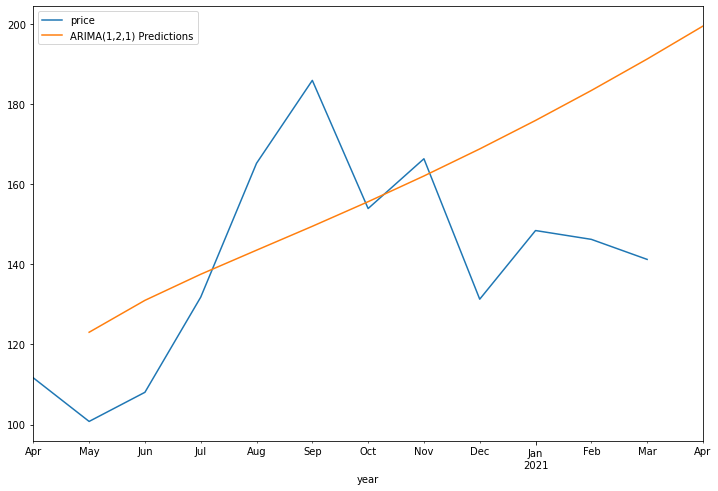

In [33]:
test_data['price'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True)

In [36]:
#check for error terms
from sklearn.metrics import mean_squared_error

error1 = mean_squared_error(test_data['price'], predictions)
print(error1)

992.0997718275436


In [37]:
from statsmodels.tools.eval_measures import rmse

error2 = rmse(test_data['price'], predictions)
print(f'ARIMA(1,1,1) rmse Error: {error2:11.10}')

ARIMA(1,1,1) rmse Error: 31.49761534


In [39]:
print(test_data['price'].mean())
print(predictions.mean())

140.8791666666667
160.05310804731744


In [41]:
#forecast to future values
model = ARIMA(df['price'], order=(1,2,1))
results = model.fit()


In [43]:
#period of 11 months
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('ARIMA(1,2,1) Forecast')
print(fcast)

2021-04-01    144.928881
2021-05-01    147.890378
2021-06-01    151.028482
2021-07-01    154.249354
2021-08-01    157.562322
2021-09-01    160.966459
2021-10-01    164.461856
2021-11-01    168.048506
2021-12-01    171.726408
2022-01-01    175.495563
2022-02-01    179.355970
2022-03-01    183.307630
Freq: MS, Name: ARIMA(1,2,1) Forecast, dtype: float64


<AxesSubplot:xlabel='year'>

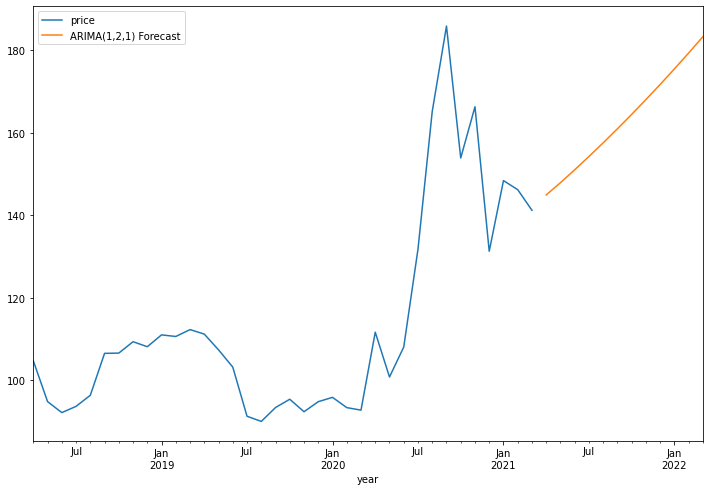

In [45]:
df['price'].plot(legend=True, figsize=(12,8))
fcast.plot(legend=True)